# Finding a place to establish a 5-star hotel in the historic city of Isfahan

#### First, importing all required libraries

In [400]:
!pip -q install folium
import numpy as np
import pandas as pd
from  matplotlib import pyplot
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import folium
from pandas import json_normalize
from sklearn.cluster import KMeans
import json
import requests
from geopy.geocoders import Nominatim
%matplotlib inline

In [401]:
address = 'Isfahan, Iran'
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
#CLIENT_ID = 'KEPUSTPUVXN5GXONYUGIQACULCQCJ0HDAPZKIK4OJ253VLXE' 
#CLIENT_ID = 'GWWGQ2C155LWDQTUENNLRUM3VRGX0U35UMHFC4MY10A1MXFT'
CLIENT_ID = 'Y5LNQE4M4EI5RNJFKYYV2YEINWC5IBJEEP4BGNVY51VEBAQU'
#CLIENT_SECRET = 'TFH1EYBLEHZXGVS3K3IOBOYJ35GRDDTC4NZTKSWNH5QNXORM' 
#CLIENT_SECRET = 'GYVZPYQSADRG4YFUR1LUGXVVK2WZBIUIJRS1CKZJWMGZMGPT' 
CLIENT_SECRET = '45UDYPJKQRM0WPZ5XEIWW1CUFDACHHXLMQZNF5HGSVVTAFHT'
VERSION = '20180605' 
#LIMIT = 100 
#radius = 40000
#url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
#results = requests.get(url).json()

In [402]:
#results

In [403]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [404]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.id', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,id,categories,lat,lng
0,Kermani Gaz | گز کرمانی (گز کرمانی),52121bcf11d2ac3f5f528022,Candy Store,32.666476,51.678293
1,Naqsh-e Jahan Square | میدان نقش جهان (میدان ن...,4fa41bace4b0e7038a4e3b05,Plaza,32.657935,51.676874
2,Chehel Sotoon Palace | کاخ چهل ستون (کاخ چهل س...,5083a0cbe4b0ec60c5ce5bef,Historic Site,32.657763,51.673511
3,Ali Qapu Palace | کاخ عالی قاپو (کاخ عالی قاپو),50693f00e4b08e43d0d5d154,Historic Site,32.657074,51.676704
4,Sheikh Lotfollah Mosque | مسجد شیخ لطف الله (م...,5148263ee4b0bc739559a092,Mosque,32.657381,51.678423


#### Getting the information about regions of Isfahan from Wikipedia

In [405]:
url = 'https://en.wikipedia.org/wiki/Districts_of_Isfahan'
df_list = pd.read_html(url)

In [406]:
df_list[1].drop(index = 11, inplace = True)
df_list = df_list[1]

In [407]:
Isfahan = pd.DataFrame(columns=['region', 'lat', 'lng'])
geolocator = Nominatim(user_agent="foursquare_agent")
for region in df_list['region']:
    address = 'Region '+str(region)+', Isfahan, Iran'
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    Isfahan.loc[int(region)-1,'region'] = region
    Isfahan.loc[int(region)-1,'lat'] = latitude
    Isfahan.loc[int(region)-1,'lng'] = longitude
Isfahan

,region,lat,lng
0,1,32.6551,51.6566
1,2,32.6791,51.6316
2,3,32.6507,51.6871
3,4,32.6367,51.7312
4,5,32.622,51.6447
5,6,32.6153,51.6776
6,7,32.7213,51.6926
7,8,32.7042,51.646
8,9,32.6622,51.6129
9,10,32.6743,51.7389


#### But as far as I know Isfahan has 15 districts, so I explore other sources 

In [408]:
url = 'https://en.wikipedia.org/wiki/Isfahan'
df_list1 = pd.read_html(url)
df_list = df_list1[10]
header = df_list.iloc[1]
df_list.drop([0,1,17], axis =0, inplace=True)
df_list.reset_index(drop=True)
df_list.columns = header
df_list[['Farsi', 'Persian']] = df_list['Persian Name'].str.split('–', 1, expand=True)
df_list['Legal Urban Area']=df_list['Legal Urban Area'].str.extract('(\d+\.\d+)').astype(float)
df_list

1,Name,Persian Name,Legal Urban Area,Total Area of jurisdictional limit,Population,Population Density,Location within Isfahan,Farsi,Persian
2,District 1,منطقه ۱ – Mantaqe ye Yek,8.10,8.10 km2,79091,"9,764.3/km2",NaN,منطقه ۱,Mantaqe ye Yek
3,District 2,منطقه ۲ – Mantaqe ye Do,10.31,21.45 km2,69120,"3,222.4/km2",NaN,منطقه ۲,Mantaqe ye Do
4,District 3,منطقه ۳ – Mantaqe ye Se,11.52,11.52 km2,110368,"9,580.5/km2",NaN,منطقه ۳,Mantaqe ye Se
5,District 4,منطقه ۴ – Mantaqe ye Ĉahār,11.35,75.02 km2,133731,"1,782.6/km2",NaN,منطقه ۴,Mantaqe ye Ĉahār
6,District 5,منطقه ۵ – Mantaqe ye Panj,17.02,60.02 km2,150865,"2,513.6/km2",NaN,منطقه ۵,Mantaqe ye Panj
7,District 6,منطقه ۶ – Mantaqe ye Ŝeŝ,12.55,67.07 km2,112129,"1,671.2/km2",NaN,منطقه ۶,Mantaqe ye Ŝeŝ
8,District 7,منطقه ۷ – Mantaqe ye Haft,13.57,28.57 km2,168732,"5,905.6/km2",NaN,منطقه ۷,Mantaqe ye Haft
9,District 8,منطقه ۸ – Mantaqe ye Haŝt,20.39,20.39 km2,239756,"11,758.5/km2",NaN,منطقه ۸,Mantaqe ye Haŝt
10,District 9,منطقه ۹ – Mantaqe ye Noh,10.54,20.25 km2,75168,"3,712.0/km2",NaN,منطقه ۹,Mantaqe ye Noh
11,District 10,منطقه ۱۰ – Mantaqe ye Dah,16.27,21.46 km2,207803,"9,683.3/km2",NaN,منطقه ۱۰,Mantaqe ye Dah


In [409]:
Isfahan = pd.DataFrame(columns=['region', 'lat', 'lng', 'area', 'radius'])
geolocator = Nominatim(user_agent="foursquare_agent")
for region in df_list.index:
    #address = str(df_list.loc[region, 'Name'])+', Isfahan, Iran'
    address = str(df_list.loc[region, 'Farsi'])+' ، اصفهان، ایران'
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
#    address1 = 'شهرداری '+str(df_list.loc[region, 'Farsi'])+' ، اصفهان، ایران'
#    location1 = geolocator.geocode(address1)
#    latitude1 = location1.latitude
#    longitude1 = location1.longitude
    Isfahan.loc[int(region)-2,'region'] = region-1
    Isfahan.loc[int(region)-2,'lat'] = latitude
    Isfahan.loc[int(region)-2,'lng'] = longitude
#    Isfahan.loc[int(region)-2,'lat1'] = latitude1
#    Isfahan.loc[int(region)-2,'lng1'] = longitude1
    Isfahan.loc[int(region)-2,'area'] = df_list.loc[region, 'Legal Urban Area']
    Isfahan.loc[int(region)-2,'radius'] = ((((df_list.loc[region, 'Legal Urban Area'])/(np.pi))**(0.5))*1000).round().astype(int)
Isfahan

,region,lat,lng,area,radius
0,1,32.6743,51.7389,8.1,1606
1,2,32.6791,51.6316,10.31,1812
2,3,32.6507,51.6871,11.52,1915
3,4,32.6367,51.7312,11.35,1901
4,5,32.622,51.6447,17.02,2328
5,6,32.6153,51.6776,12.55,1999
6,7,32.7213,51.6926,13.57,2078
7,8,32.7042,51.646,20.39,2548
8,9,32.6622,51.6129,10.54,1832
9,10,32.6743,51.7389,16.27,2276


#### Considering that each district have different areas, we calculated the estimated radius of each region to use

In [410]:
LIMIT = 200
def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng, rad in zip(names, latitudes, longitudes, radius):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            rad+100, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            lat, 
            lng, 
            v['venue']['name'],
            v['venue']['id'],            
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

        # create the API request URL
#        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
#            CLIENT_ID, 
#            CLIENT_SECRET, 
#            VERSION, 
#            lat1, 
#            lng1, 
#            rad, 
#            LIMIT)
#            
        # make the GET request
#        results = requests.get(url).json()["response"]['groups'][0]['items']
#        
        # return only relevant information for each nearby venue
#        venues_list.append([(
#            name,
#            lat1, 
#            lng1, 
#            v['venue']['name'],
#            v['venue']['id'],            
#            v['venue']['location']['lat'], 
#            v['venue']['location']['lng'],  
#            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Region', 
                  'Region Latitude', 
                  'Region Longitude', 
                  'Venue', 
                  'Venue ID',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [411]:
isfahan_venues = getNearbyVenues(names=Isfahan['region'],
                                   latitudes=Isfahan['lat'],
                                   longitudes=Isfahan['lng'],
#                                   latitudes1=Isfahan['lat1'],
#                                   longitudes1=Isfahan['lng1'],
                                   radius=Isfahan['radius']
                                  )

In [412]:
isfahan_venues.drop_duplicates(subset='Venue ID', inplace=True)
#isfahan_venues.reset_index(inplace=True)
isfahan_venues

,Region,Region Latitude,Region Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
0,1,32.674274,51.738949,Kowsar Store | فروشگاه زنجیره‌ای کوثر,52b9b1b1498e74d5ee301622,32.680686,51.736004,Department Store
1,1,32.674274,51.738949,Khaneh Moallem Hostel | خانه معلم اصفهان,52ee7c81498efdf630e95d32,32.680174,51.724773,Hostel
2,1,32.674274,51.738949,Aftab Saloon,54c14ab7498e8530fdb260ac,32.661186,51.732885,Persian Restaurant
3,1,32.674274,51.738949,Tamadon Fish Market,5af6e22e32b61d002cb313bc,32.689170,51.736490,Fish Market
4,2,32.679096,51.631612,ورزشگاه ملت ذوب آهن,563a3b50cd101fc97444c792,32.681897,51.637654,Football Stadium
...,...,...,...,...,...,...,...,...
307,15,32.728048,51.593674,بازار کوثر اصفهان,5a61a49260255e18e3b1b3da,32.720920,51.589530,Supermarket
308,15,32.728048,51.593674,Feren Harari Auto Clinic | كلينيك اتومبيل فرن ...,53eb6a4f498eded9dcbf5964,32.727006,51.580463,Auto Garage
309,15,32.728048,51.593674,Aria Complex,5a965c90270ee773ba36b771,32.739416,51.586471,Paper / Office Supplies Store
310,15,32.728048,51.593674,Ashayer Kebab House |كبابي و برياني عشاير,598c3526345cbe1f605de379,32.734042,51.571990,Kebab Restaurant


#### I check wether my search could find venues in all the regions and get a scence of how dense is each region

In [413]:
isfisf = isfahan_venues.groupby('Region').count()
isfisf = isfisf.sort_values(by='Venue', ascending=False)
isfisf

,Region Latitude,Region Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
Region,,,,,,,
3,94,94,94,94,94,94,94
5,82,82,82,82,82,82,82
6,46,46,46,46,46,46,46
8,11,11,11,11,11,11,11
10,9,9,9,9,9,9,9
15,6,6,6,6,6,6,6
13,5,5,5,5,5,5,5
1,4,4,4,4,4,4,4
2,4,4,4,4,4,4,4


In [414]:
# create map
address = 'Isfahan, Iran'
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
map_venues = folium.Map(location=[latitude, longitude], zoom_start=12)
regions = isfahan_venues['Region']
# set color scheme for the regions
x = np.arange(15)
ys = [i + x + (i*x)**3 for i in range(15)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for venue, lat, lon, region in zip(isfahan_venues['Venue'], isfahan_venues['Venue Latitude'], isfahan_venues['Venue Longitude'], isfahan_venues['Region']):
    label = folium.Popup(venue, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(region)-1],
        fill=True,
        fill_color=rainbow[int(region)-1],
        fill_opacity=0.7).add_to(map_venues)
       
map_venues

#### I only need the information about the Hotels and Historic sites, but it seems many tourism attractions have different Venue Categories. Therefore, I included them as well as hostels.

In [426]:
isfahan_historic = isfahan_venues[(isfahan_venues['Venue Category']=='Historic')]
isfahan_hotel = isfahan_venues[(isfahan_venues['Venue Category']=='Hotel')]
isfahan_hotel = isfahan_venues[isfahan_venues['Venue Category'].str.contains('Hotel')]
isfahan_hostel = isfahan_venues[isfahan_venues['Venue Category'].str.contains('Hostel')]
isfahan_plaza = isfahan_venues[isfahan_venues['Venue Category'].str.contains('Plaza')]
isfahan_bridge = isfahan_venues[isfahan_venues['Venue Category'].str.contains('Bridge')]
isfahan_historic = isfahan_venues[isfahan_venues['Venue Category'].str.contains('Histo')]
isfahan_mosque = isfahan_venues[isfahan_venues['Venue Category'].str.contains('Mosq')]
isfahan_church = isfahan_venues[isfahan_venues['Venue Category'].str.contains('Chur')]
isfahan_museum = isfahan_venues[isfahan_venues['Venue Category'].str.contains('Museum')]
isfahan_garden = isfahan_venues[isfahan_venues['Venue Category'].str.contains('Garden')]
isfahan_persian = isfahan_venues[isfahan_venues['Venue Category'].str.contains('Persian')]
isfahan_target = pd.concat([isfahan_persian, isfahan_garden, isfahan_historic, isfahan_hotel, isfahan_mosque, isfahan_church, isfahan_museum, isfahan_hostel, isfahan_plaza, isfahan_bridge])
#isfahan_target.reset_index(inplace=True)
#isfahan_target.drop(columns='index', inplace=True)
#isfahan_target.drop(columns='level_0', inplace=True)
isfahan_target

,Region,Region Latitude,Region Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
2,1,32.674274,51.738949,Aftab Saloon,54c14ab7498e8530fdb260ac,32.661186,51.732885,Persian Restaurant
36,3,32.650733,51.687073,Golestan Beryani | بريانى گلستان,55449e9f498e0442b07b8c9c,32.659356,51.672794,Persian Restaurant
53,3,32.650733,51.687073,Azam Beryani | بریانی اعظم (بریانی اعظم),5332b02a498e93f05020fd88,32.638035,51.680289,Persian Restaurant
56,3,32.650733,51.687073,Shafaat Beryani | بریانی حاج محمود شفاعت (بریا...,512f3c6be4b0aa2e91473cec,32.667844,51.683986,Persian Restaurant
59,3,32.650733,51.687073,Shahrzad Restaurant | رستوران شهرزاد (رستوران ...,4f04bc4130f8dd7f43740c5a,32.648755,51.667352,Persian Restaurant
65,3,32.650733,51.687073,Shaad Beryani | بریانی شاد (بریانی شاد),50446743e4b0f306730de325,32.657243,51.668652,Persian Restaurant
70,3,32.650733,51.687073,Safaviyeh Traditional Restaurant | سفره‌خانه س...,52b8129a11d2898280a4a6a6,32.659945,51.683847,Persian Restaurant
100,3,32.650733,51.687073,Shaliz | شالیز (شالیز),530dc52d498e5d096d7a8bdb,32.634238,51.680414,Persian Restaurant
120,5,32.621997,51.644698,Toranj Food Complex | مجموعه پذیرایی ترنج (مجم...,55aa1979498ed4819b3271a8,32.632567,51.651043,Persian Restaurant
144,5,32.621997,51.644698,Zhuan Restaurant | رستوران ژوان,5978d67cf427de3df2565315,32.625744,51.626316,Persian Restaurant


#### Now, I extract the ratings of each Hotel or Historic site from the Foursquare API

In [427]:
for ID in isfahan_target['Venue ID']:
    url = 'https://api.foursquare.com/v2/venues/{}'.format(ID)
#url = 'https://api.foursquare.com/v2/venues/{}'.format('512008ece4b0d60613492b14')
    params = dict(client_id=CLIENT_ID,client_secret=CLIENT_SECRET,v=VERSION)
    result = requests.get(url, params=params).json()
    try:
        isfahan_target.loc[isfahan_target['Venue ID'] == ID, 'Venue Rating'] = result['response']['venue']['rating'] 
    except:
        isfahan_target.loc[isfahan_target['Venue ID'] == ID, 'Venue Rating'] = 5 #I set the low rating of 5 for the venues without rating

In [428]:
isfahan_target

,Region,Region Latitude,Region Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category,Venue Rating
2,1,32.674274,51.738949,Aftab Saloon,54c14ab7498e8530fdb260ac,32.661186,51.732885,Persian Restaurant,5.0
36,3,32.650733,51.687073,Golestan Beryani | بريانى گلستان,55449e9f498e0442b07b8c9c,32.659356,51.672794,Persian Restaurant,8.6
53,3,32.650733,51.687073,Azam Beryani | بریانی اعظم (بریانی اعظم),5332b02a498e93f05020fd88,32.638035,51.680289,Persian Restaurant,7.9
56,3,32.650733,51.687073,Shafaat Beryani | بریانی حاج محمود شفاعت (بریا...,512f3c6be4b0aa2e91473cec,32.667844,51.683986,Persian Restaurant,8.4
59,3,32.650733,51.687073,Shahrzad Restaurant | رستوران شهرزاد (رستوران ...,4f04bc4130f8dd7f43740c5a,32.648755,51.667352,Persian Restaurant,8.2
65,3,32.650733,51.687073,Shaad Beryani | بریانی شاد (بریانی شاد),50446743e4b0f306730de325,32.657243,51.668652,Persian Restaurant,8.0
70,3,32.650733,51.687073,Safaviyeh Traditional Restaurant | سفره‌خانه س...,52b8129a11d2898280a4a6a6,32.659945,51.683847,Persian Restaurant,7.1
100,3,32.650733,51.687073,Shaliz | شالیز (شالیز),530dc52d498e5d096d7a8bdb,32.634238,51.680414,Persian Restaurant,5.0
120,5,32.621997,51.644698,Toranj Food Complex | مجموعه پذیرایی ترنج (مجم...,55aa1979498ed4819b3271a8,32.632567,51.651043,Persian Restaurant,7.9
144,5,32.621997,51.644698,Zhuan Restaurant | رستوران ژوان,5978d67cf427de3df2565315,32.625744,51.626316,Persian Restaurant,7.5


#### Then, I group the table by regions, showing the total ratings of the Hotels and total ratings of Historic sites 

In [442]:
isfahan_target.loc[isfahan_target['Venue Category']=='Plaza', 'Venue Category'] = 'Historic Site'
isfahan_target.loc[isfahan_target['Venue Category']=='Bridge', 'Venue Category'] = 'Historic Site'
isfahan_target.loc[isfahan_target['Venue Category']=='Church', 'Venue Category'] = 'Historic Site'
isfahan_target.loc[isfahan_target['Venue Category']=='Pedestrian Plaza', 'Venue Category'] = 'Historic Site'
isfahan_target.loc[isfahan_target['Venue Category']=='Shopping Plaza', 'Venue Category'] = 'Historic Site'
isfahan_target.loc[isfahan_target['Venue Category']=='Persian Restaurant', 'Venue Category'] = 'Historic Site'
isfahan_target.loc[isfahan_target['Venue Category']=='History Museum', 'Venue Category'] = 'Historic Site'
isfahan_target.loc[isfahan_target['Venue Category']=='Art Museum', 'Venue Category'] = 'Historic Site'
isfahan_target.loc[isfahan_target['Venue Category']=='Garden', 'Venue Category'] = 'Historic Site'
isfahan_target.loc[isfahan_target['Venue Category']=='Mosque', 'Venue Category'] = 'Historic Site'
isfahan_target.loc[isfahan_target['Venue Category']=='Hostel', 'Venue Category'] = 'Hotel'
isfahan_historic = isfahan_target[(isfahan_target['Venue Category']=='Historic Site')]
isfahan_hotel = isfahan_target[(isfahan_target['Venue Category']=='Hotel')]
historic = isfahan_historic.groupby('Region').mean()
historic.reset_index(inplace=True)
historic.rename(columns={'Venue Rating':'Tourism Attractions Rating'}, inplace=True)
hotels = isfahan_hotel.groupby('Region').mean()
hotels.reset_index(inplace=True)
hotels.rename(columns={'Venue Rating':'Accommodations Rating'}, inplace=True)

In [443]:
merged = pd.merge(hotels, historic, 'left', on=['Region'])
merged.drop(['Venue Latitude_x', 'Venue Longitude_x', 'Region Latitude_x', 'Region Longitude_x', 'Region Latitude_y', 'Region Longitude_y', 'Venue Latitude_y', 'Venue Longitude_y'], axis=1, inplace=True)
for i in range(15):
    if i+1 in merged['Region'].values:        
        pass
    else:
        merged.loc[len(merged.index)+1, 'Region']=i+1 
merged.fillna(0, inplace=True)
Regions = merged.sort_values(by='Region')
Regions

,Region,Accommodations Rating,Tourism Attractions Rating
0,1.0,5.6000,5.000000
1,2.0,5.0000,5.500000
2,3.0,7.0875,8.143478
6,4.0,0.0000,0.000000
3,5.0,6.4500,7.616667
7,6.0,0.0000,0.000000
8,7.0,0.0000,0.000000
9,8.0,0.0000,0.000000
10,9.0,0.0000,0.000000
4,10.0,5.4500,5.000000


#### I cluster data to four clusters. I'm looking for regions with:
#### - High Accommodations Rating, High Tourism Attractions Rating
#### - High Accommodations Rating, Low Tourism Attractions Rating
#### - Low Accommodations Rating, High Tourism Attractions Rating ----> These are our intended regions!
#### - Low Accommodations Rating, Low Tourism Attractions Rating

In [444]:
# set number of clusters
kclusters = 4
Regions_clustering = Regions.drop('Region', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Regions_clustering)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:15]

array([3, 1, 2, 0, 2, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0], dtype=int32)

#### Adding Cluster Labels to the Regions table

In [454]:
#Regions.insert(0, 'Cluster Labels', kmeans.labels_)
Regions['Ratio'] = Regions['Tourism Attractions Rating'] / Regions['Accommodations Rating']
Regions = Regions.sort_values(by='Ratio', ascending = False)
Regions

,Cluster Labels,Region,Accommodations Rating,Tourism Attractions Rating,Ratio
3,2,5.0,6.4500,7.616667,1.180879
2,2,3.0,7.0875,8.143478,1.148992
1,1,2.0,5.0000,5.500000,1.100000
4,3,10.0,5.4500,5.000000,0.917431
0,3,1.0,5.6000,5.000000,0.892857
6,0,4.0,0.0000,0.000000,NaN
7,0,6.0,0.0000,0.000000,NaN
8,0,7.0,0.0000,0.000000,NaN
9,0,8.0,0.0000,0.000000,NaN
10,0,9.0,0.0000,0.000000,NaN


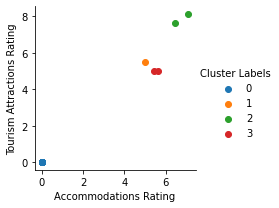

In [469]:
fg = sns.FacetGrid(data=Regions, hue='Cluster Labels', aspect=1)
fg.map(pyplot.scatter, 'Accommodations Rating', 'Tourism Attractions Rating').add_legend()

#### Regions in cluster 0 have no tourism attraction rating and consequently no accommodation rating. Clearly, they are not good locations for a new hotel.
#### Region in cluster 1 has higher tourism attraction rating than accommodation rating. It may suitable at first glance, but it when we consider the tourism attraction rating, it is very low. Therefore it could not be an attractive place for tourists, and so it doesn't worth to establish a high quality hotel in this location.
#### Regions in cluster 3 have higher accommodation rating than tourism attraction rating. It means that they have enough hotels to serve the tourists with regard to their tourism attractions.
#### Regions in cluster 2 have high tourism attraction rating and high accommodation rating. However, their tourism attraction ratings are higher than their accommodation ratings, so they are good choices of location for a new high quality hotel.

# So, Regions 3 and 5 are the best locations to be introduced to the enterprise group!
# Region 5 is the best choice because it has the highest ratio of Tourism Attractions Rating to Accommodations Rating.